# Технологии искусственного интеллекта. Семестр 1

© Петров М.В., старший преподаватель кафедры суперкомпьютеров и общей информатики, Самарский университет

## Лекция 3. Задачи классификации. Метрики качества

### Содержание

1. [Введение](#3.1-Введение)
2. [Метод $k$-ближайших соседей](#3.2-Метод-k-ближайших-соседей)
3. [Датасет `Rain in Australia` для бинарной классификации](#3.3-Датасет-Rain-in-Australia-для-бинарной-классификации)
4. [Подготовка данных](#3.4-Подготовка-данных)
5. [Кодирование признака](#3.5-Кодирование-признака)
6. [Подготовка данных (продолжение)](#3.6-Подготовка-данных-(продолжение))
7. [Обучение и предсказание](#3.7-Обучение-и-предсказание)
8. [Оценка качества модели](#3.8-Оценка-качества-модели)
9. [Метрики оценки точности бинарной классификации](#3.9-Метрики-оценки-точности-бинарной-классификации)

### 3.1 Введение

Гайды:
- [Открытый курс машинного обучения. Тема 3. Классификация, деревья решений и метод ближайших соседей](https://habr.com/ru/companies/ods/articles/322534/)

Классическое, общее определение машинного обучения звучит так (T. Mitchell "Machine learning", 1997):
> Говорят, что компьютерная программа обучается при решении какой-то задачи из класса $T$, если ее производительность, согласно метрике $P$, улучшается при накоплении опыта $E$.

Среди самых популярных задач $T$ в машинном обучении:
- Классификация &ndash; отнесение объекта к одной из категорий на основании его признаков.
- Регрессия &ndash; прогнозирование количественного признака объекта на основании прочих его признаков.
- Кластеризация &ndash; разбиение множества объектов на группы на основании признаков этих объектов так, чтобы внутри групп объекты были похожи между собой, а вне одной группы &ndash; менее похожи.
- Нахождение аномалий &ndash; поиск объектов, "сильно непохожих" на все остальные в выборке, либо на какую-то группу объектов.
- Другие задачи, более специфичные. Хороший обзор дан в главе "Machine Learning basics" книги ["Deep Learning": Ian Goodfellow, Yoshua Bengio, Aaron Courville, 2016](http://www.deeplearningbook.org/).

Под опытом $E$ понимаются данные, и в зависимости от данных алгоритмы машинного обучения разделяются на 2 вида:
- обучение с учителем &ndash; `supervised learning`;
- обучение без учителя &ndash; `unsupervised learning`.

В задачах обучения без учителя имеется выборка, состоящая из объектов, описываемых набором признаков. В задачах обучения с учителем вдобавок к этому для каждого объекта некоторой выборки, называемой обучающей, известен целевой признак &ndash; по сути это то, что хотелось бы прогнозировать для прочих объектов, не из обучающей выборки.

#### Пример

Задачи классификации и регрессии &ndash; это задачи обучения с учителем. В качестве примера будем представлять задачу кредитного скоринга: на основе накопленных кредитной организацией данных о своих клиентах хочется прогнозировать *невозврат кредита*. Здесь для алгоритма опыт $E$ &ndash; это имеющаяся обучающая выборка: набор объектов (людей), каждый из которых характеризуется набором признаков (таких как *возраст*, *зарплата*, *тип кредита*, *невозвраты в прошлом* и т.д.), а также целевым признаком. Если этот целевой признак &ndash; просто факт *невозврата кредита* ($1$ или $0$, т.е. банк знает о своих клиентах, кто вернул кредит, а кто &ndash; нет), то это задача (бинарной) ***классификации***. Если известно, *на сколько по времени клиент затянул с возвратом кредита*, и хочется то же самое прогнозировать для новых клиентов, то это будет задачей ***регрессии***.

### 3.2 Метод $k$-ближайших соседей

Метод $k$-ближайших соседей (`k-nearest neighbors algorithm`, `k-NN`) &ndash; метрический алгоритм для автоматической классификации объектов или регрессии.
В случае использования метода для классификации объект присваивается тому классу, который является наиболее распространённым среди $k$ соседей данного элемента, классы которых уже известны.
Алгоритм может быть применим к выборкам с большим количеством атрибутов (многомерным). Для этого перед применением нужно определить функцию расстояния; классический вариант такой функции &ndash; *евклидова метрика*.

Разные атрибуты могут иметь разный диапазон представленных значений в выборке (например атрибут $А$ представлен в диапазоне от $0.1$ до $0.5$, а атрибут $Б$ представлен в диапазоне от $1000$ до $5000$), то значения дистанции могут сильно зависеть от атрибутов с бо́льшими диапазонами. Поэтому данные обычно подлежат *нормализации*.

#### Датасет &ndash; Ирисы Фишера

[Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0) состоят из данных о $150$ экземплярах ириса, по $50$ экземпляров из трёх видов &ndash; `Ирис щетинистый` (`Iris setosa`), `Ирис виргинский` (`Iris virginica`) и `Ирис разноцветный` (`Iris versicolor`).
Для каждого экземпляра измерялись четыре характеристики (в сантиметрах):
- Длина наружной доли околоцветника (англ. `sepal length`);
- Ширина наружной доли околоцветника (англ. `sepal width`);
- Длина внутренней доли околоцветника (англ. `petal length`);
- Ширина внутренней доли околоцветника (англ. `petal width`).

На основании этого набора данных требуется построить правило классификации, определяющее *вид растения* по данным измерений. Это задача многоклассовой классификации, так как имеется три класса &ndash; три вида ириса.
Один из классов (`Iris setosa`) линейно-разделим от двух остальных.

In [1]:
import sklearn
from sklearn import datasets
dataset = datasets.load_iris()
print(sklearn.__version__)
print(list(dataset.keys()))

1.4.1.post1
['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module']


In [2]:
# Значение ключа DESCR – это краткое описание набора данных
print(dataset['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [3]:
# Значение ключа target_names – массив меток классов (в данном случае сорта цветов)
list(dataset['target_names'])

['setosa', 'versicolor', 'virginica']

In [4]:
# Список названий полей-признаков
list(dataset['feature_names'])

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [5]:
# Сами признаки записаны в numpy-массиве data
type(dataset['data']), dataset['data'].shape

(numpy.ndarray, (150, 4))

In [6]:
# Первые пять строк массива data
dataset['data'][:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [7]:
# "Ответы" записаны в target
type(dataset['target']), dataset['target'].shape

(numpy.ndarray, (150,))

In [8]:
print(dataset['target'])
# Значения чисел задаются массивом target_names: 0 – setosa, 1 – versicolor, а 2 – virginica.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


#### Разделение выборки на обучающую и тестовую

Разобьём весь датасет на две части. Одна часть данных используется для построения модели машинного обучения и называется *обучающими данными* (*training data*) или *обучающим набором* (*training set*). Остальные данные будут использованы для оценки качества модели, их называют *тестовыми данными* (*test data*), *тестовым набором* (*test set*) или *контрольным набором* (*hold-out set*).

<div align="center">
  <img src="images/l3_1.svg" width="500" title="Обучение и тестирование модели"/>
  <p style="text-align: center">
    Рисунок 1 &ndash; Обучение и тестирование модели
  </p>
</div>

> Также для некоторых моделей часть данных из обущающей выборки выделяется в валидационный набор, который используется для вычисления метрик во время обучения.

Обычно отбирают в обучающий набор $70\text{-}80\%$ строк данных, и оставшиеся $\%$ объявляются тестовым набором.
В библиотеке `scikit-learn` есть функция `train_test_split`, которая перемешивает набор данных и разбивает его на две части.

In [9]:
from sklearn.model_selection import train_test_split
ex_X, ex_y = dataset.data, dataset.target
# Для упрощения визуализации оставим только 2 признака
ex_X = ex_X[:, :2]

ex_X_train, ex_X_test, ex_y_train, ex_y_test = train_test_split(
    ex_X, ex_y, stratify=ex_y, train_size=0.75, random_state=42
)

In [10]:
print(f"X_train shape: {ex_X_train.shape}")
print(f"y_train shape: {ex_y_train.shape}")
print(f"X_test shape: {ex_X_test.shape}")
print(f"y_test shape: {ex_y_test.shape}")

X_train shape: (112, 2)
y_train shape: (112,)
X_test shape: (38, 2)
y_test shape: (38,)


#### Создание объекта алгоритма/модели-предсказателя

В `sklearn` все модели машинного обучения реализованы в собственных классах, называемых классами `Estimator`. Алгоритм классификации на основе метода k ближайших соседей реализован в классификаторе [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) модуля `sklearn.neighbors`. Прежде чем использовать эту модель, нам нужно создать объект-экземпляр класса, указав параметры модели. Самым важным параметром `KNeighborsClassifier` является количество соседей, которые мы установим равным $3$.

In [11]:
from sklearn.neighbors import KNeighborsClassifier
ex_model_knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')

#### Обучение модели

In [12]:
ex_model_knn.fit(ex_X_train, ex_y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [13]:
import pandas as pd
import numpy as np
# magic function - см. Interactive Plotting
%matplotlib inline
%matplotlib widget
from ipywidgets import *
import matplotlib.pyplot as plt
# см. https://ipython.readthedocs.io/en/stable/interactive/plotting.html
# Starting with IPython 5.0 and matplotlib 2.0 you can avoid the use of IPython’s specific magic
# and use matplotlib.pyplot.ion()/matplotlib.pyplot.ioff() which have the advantages of working outside of IPython as well.
# plt.ion()
import seaborn as sns

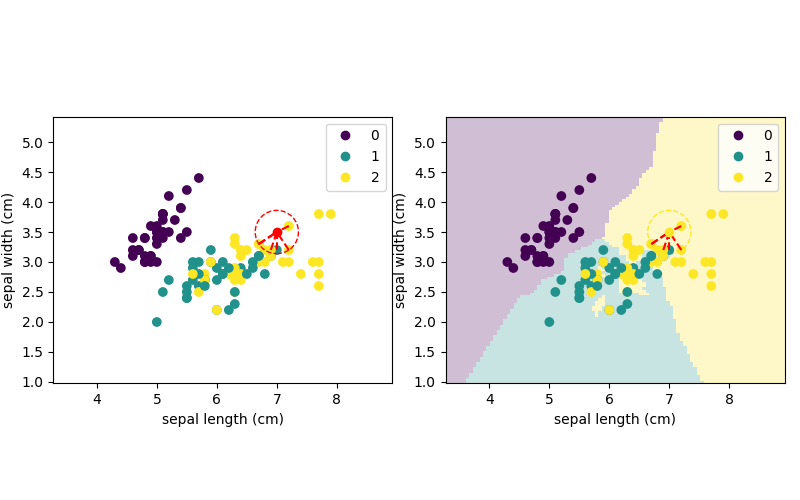

In [14]:
from sklearn.metrics import DistanceMetric

# Тестовая точка - sepal length, width
test_point = [7, 3.5]
tpp = ex_model_knn.predict([test_point])

# Ближайшие 6 соседей
n_d, n_i = ex_model_knn.kneighbors([test_point], n_neighbors=6, return_distance=True)
points = np.reshape(ex_X_train[n_i].ravel(), (-1, 2))

from sklearn.inspection import DecisionBoundaryDisplay
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
sc = ax[0].scatter(ex_X_train[:, 0], ex_X_train[:, 1], c=ex_y_train)
ax[0].legend(*sc.legend_elements())
ax[0].set_xlabel(dataset.feature_names[0])
ax[0].set_ylabel(dataset.feature_names[1])
scc = sc.get_cmap()

ax[0].plot(test_point[0], test_point[1], 'ro')
circle = plt.Circle((test_point), np.max(n_d), color='r', ls='--', fill=False)
ax[0].add_patch(circle)
for i in range(6):
    p = points[i, :]
    p = np.vstack((p, test_point))
    ax[0].plot(p[:, 0], p[:, 1], 'r--')

DecisionBoundaryDisplay.from_estimator(
        ex_model_knn,
        ex_X,
        alpha=0.25,
        ax=ax[1],
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=dataset.feature_names[0],
        ylabel=dataset.feature_names[1],
        shading="auto",
    )
circle = plt.Circle((test_point), np.max(n_d), color=scc(tpp/2), ls='--', fill=False)
ax[1].add_patch(circle)
ax[1].scatter(ex_X_train[:, 0], ex_X_train[:, 1], c=ex_y_train)
ax[1].legend(*sc.legend_elements())
for i in range(6):
    p = points[i, :]
    p = np.vstack((p, test_point))
    ax[1].plot(p[:, 0], p[:, 1], ls = '--', color = 'r')
ax[1].plot(test_point[0], test_point[1], marker='o', color = scc(tpp/2))
ax[0].set_xlim(ax[1].get_xlim())
ax[0].set_ylim(ax[1].get_ylim())
fig.tight_layout()
plt.show()

### 3.3 Датасет [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) для бинарной классификации

#### Описание датасета

Датасет содержит данные о метеонаблюдениях в Австралии, цель &ndash; прогнозирование дождя на следующий день. Целевой признак &ndash; `RainTomorrow`.

| Признак       | Описание                                                                                               | Единицы измерения   |
|---------------|--------------------------------------------------------------------------------------------------------|---------------------|
| Location      | The common name of the location of the weather station                                                 |
| MinTemp       | Minimum temperature in the 24 hours to 9am. Sometimes only known to the nearest whole degree.          | degrees Celsius
| MaxTemp       | Maximum temperature in the 24 hours from 9am. Sometimes only known to the nearest whole degree.        | degrees Celsius
| Rainfall      | Precipitation (rainfall) in the 24 hours to 9am. Sometimes only known to the nearest whole millimetre. | millimetres
| Sunshine      | Bright sunshine in the 24 hours to midnight                                                            | hours
| WindGustDir   | Direction of strongest gust in the 24 hours to midnight                                                | 16 compass points
| WindGustSpeed | Speed of strongest wind gust in the 24 hours to midnight                                               | kilometres per hour
| WindDir9am    | Wind direction averaged over 10 minutes prior to 9 am                                                  | compass points
| WindDir3pm    | Wind direction averaged over 10 minutes prior to 3 pm                                                  | compass points
| WindSpeed9am  | Wind speed averaged over 10 minutes prior to 9 am                                                      | kilometres per hour
| WindSpeed3pm  | Wind speed averaged over 10 minutes prior to 3 pm                                                      | kilometres per hour
| Humidity9am   | Relative humidity at 9 am                                                                              | percent
| Humidity3pm   | Relative humidity at 3 pm                                                                              | percent
| Pressure9am   | Atmospheric pressure reduced to mean sea level at 9 am                                                 | hectopascals
| Pressure3pm   | Atmospheric pressure reduced to mean sea level at 3 pm                                                 | hectopascals
| Cloud9am      | Fraction of sky obscured by cloud at 9 am                                                              | eighths
| Cloud3pm      | Fraction of sky obscured by cloud at 3 pm                                                              | eighths
| Temp9am       | Temperature at 9 am                                                                                    | degrees Celsius
| Temp3pm       | Temperature at 3 pm                                                                                    | degrees Celsius
| RainToday     | The rain for that day was 1mm or more                                                                  | Yes or No
| RainTomorrow  | The rain for that day was 1mm or more. The target variable to predict.                                 | Yes or No

In [15]:
import pandas as pd
import numpy as np
# magic function - см. Interactive Plotting
%matplotlib inline
%matplotlib widget
from ipywidgets import *
import matplotlib.pyplot as plt
# см. https://ipython.readthedocs.io/en/stable/interactive/plotting.html
# Starting with IPython 5.0 and matplotlib 2.0 you can avoid the use of IPython’s specific magic
# and use matplotlib.pyplot.ion()/matplotlib.pyplot.ioff() which have the advantages of working outside of IPython as well.
# plt.ion()
import seaborn as sns
from pathlib import Path
# путь к папке с данными
data_path = "../lecture_3/data"
# датасет: Rain in Australia: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
df = pd.read_csv(Path(data_path, 'weatherAUS.csv'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [16]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [17]:
df.describe(include='all')

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,145460,145460,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135134,135197.000000,134894,...,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000,142199,142193
unique,3436,49,NaN,NaN,NaN,NaN,NaN,16,NaN,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,2013-11-12,Canberra,NaN,NaN,NaN,NaN,NaN,W,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
freq,49,3436,NaN,NaN,NaN,NaN,NaN,9915,NaN,11758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110319,110316
mean,NaN,NaN,12.194034,23.221348,2.360918,5.468232,7.611178,NaN,40.035230,NaN,...,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339,NaN,NaN
std,NaN,NaN,6.398495,7.119049,8.478060,4.193704,3.785483,NaN,13.607062,NaN,...,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665,NaN,NaN
min,NaN,NaN,-8.500000,-4.800000,0.000000,0.000000,0.000000,NaN,6.000000,NaN,...,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000,NaN,NaN
25%,NaN,NaN,7.600000,17.900000,0.000000,2.600000,4.800000,NaN,31.000000,NaN,...,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000,NaN,NaN
50%,NaN,NaN,12.000000,22.600000,0.000000,4.800000,8.400000,NaN,39.000000,NaN,...,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000,NaN,NaN
75%,NaN,NaN,16.900000,28.200000,0.800000,7.400000,10.600000,NaN,48.000000,NaN,...,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000,NaN,NaN


### 3.4 Подготовка данных
#### Проверка целевого признака `RainTomorrow`

In [18]:
df['RainTomorrow'].isnull().sum()

3267

Дропнем строки с null.

In [19]:
df = df.drop(df[df['RainTomorrow'].isna()].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null   fl

In [20]:
df['RainTomorrow'].value_counts()

RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64

In [21]:
df['RainTomorrow'].value_counts() / len(df)

RainTomorrow
No     0.775819
Yes    0.224181
Name: count, dtype: float64

#### Проверка категориальных признаков
##### Заполним отсутствующие значения

> [pandas.DataFrame.mode](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html) &ndash; возвращает список наиболее часто встречающихся значений.

In [22]:
# Выделим названия категориальных признаков в отдельный массив
cat_cols = [var for var in df.columns if df[var].dtype == 'object']
df[cat_cols].head()

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,W,W,WNW,No,No
1,2008-12-02,Albury,WNW,NNW,WSW,No,No
2,2008-12-03,Albury,WSW,W,WSW,No,No
3,2008-12-04,Albury,NE,SE,E,No,No
4,2008-12-05,Albury,W,ENE,NW,No,No


In [23]:
cat_null = df[cat_cols].isnull().sum()
cat_null

Date                0
Location            0
WindGustDir      9330
WindDir9am      10013
WindDir3pm       3778
RainToday        1406
RainTomorrow        0
dtype: int64

In [24]:
df[cat_null[cat_null > 0].index].mode()

,WindGustDir,WindDir9am,WindDir3pm,RainToday
0,W,N,SE,No


In [25]:
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)
df[cat_cols].isnull().sum()

C:\Users\UD\AppData\Local\Temp\ipykernel_127700\2750357519.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


Date            0
Location        0
WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

##### Мощность признаков (cardinality)
Мощность признака &ndash; количество уникальных значений признака.

In [26]:
len_max = max([len(col) for col in cat_cols])
for col in cat_cols:
    print(f"{col:<{len_max}} labels: {len(df[col].unique())}")

Date         labels: 3436
Location     labels: 49
WindGustDir  labels: 16
WindDir9am   labels: 16
WindDir3pm   labels: 16
RainToday    labels: 2
RainTomorrow labels: 2


Признак `Date` имеет высокую мощность, что может усложнить задачу классификации. Разобьем дату на составные части.

In [27]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop('Date', axis=1, inplace = True)
cat_cols.remove('Date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   MinTemp        141556 non-null  float64
 2   MaxTemp        141871 non-null  float64
 3   Rainfall       140787 non-null  float64
 4   Evaporation    81350 non-null   float64
 5   Sunshine       74377 non-null   float64
 6   WindGustDir    142193 non-null  object 
 7   WindGustSpeed  132923 non-null  float64
 8   WindDir9am     142193 non-null  object 
 9   WindDir3pm     142193 non-null  object 
 10  WindSpeed9am   140845 non-null  float64
 11  WindSpeed3pm   139563 non-null  float64
 12  Humidity9am    140419 non-null  float64
 13  Humidity3pm    138583 non-null  float64
 14  Pressure9am    128179 non-null  float64
 15  Pressure3pm    128212 non-null  float64
 16  Cloud9am       88536 non-null   float64
 17  Cloud3pm       85099 non-null   fl

##### Признак `Location`

In [28]:
print(f"\"Location\" label count: {len(df.Location.unique())}")
print(df.Location.unique())

"Location" label count: 49
['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']


### 3.5 Кодирование признака
> Кодирование категориальных признаков &ndash; преобразование категориальных признаков в численное представление по некоторым правилам.

Гайды:
- [sklearn: Encoding categorical features](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features)
- [sklearn: LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder)
- [sklearn: OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
- [pandas: factorize](https://pandas.pydata.org/docs/reference/api/pandas.factorize.html)
- [Хабр: Отличия LabelEncoder и OneHotEncoder в SciKit Learn](https://habr.com/ru/articles/456294/)
- [Хабр: Категориальные признаки](https://habr.com/ru/articles/666234/)

- `Label Encoder`  
  Преобразование представляет собой однозначное соответствие `уникальное значение категориального признака` &harr; `число`, диапазон $[0, N-1]$.
  > Главный недостаток `Label Encoder`'a &ndash; создание избыточных зависимостей в данных (порядок и количественное отношение).
  >
  > Encode target labels with value between 0 and n_classes-1.
  > This transformer should be used to encode *target values*, i.e. y, and not the input X.

  Перекодируем наш признак `Location` (только в качестве примера):
  $$
  \begin{bmatrix}
      \text{Adelaide} \\[0.3em]
      \text{Albany}   \\[0.3em]
      \text{Albury}   \\[0.3em]
      \cdots           \\[0.3em]
      \text{Woomera}  \\[0.3em]
  \end{bmatrix}_{\; 49 \times 1} \quad \rightarrow{} \quad
  \begin{bmatrix}
      0 \\[0.3em]
      1 \\[0.3em]
      2 \\[0.3em]
      \vdots \\[0.3em]
      48 \\[0.3em]
  \end{bmatrix}_{\; 49 \times 1}
  $$
- `One-Hot Encoder`  
  Каждому уникальному значению признака ставится в соответсвие бинарный вектор, состоящий из нулей и одной единицы. Каждое значение такого вектора означает принадлежность значения признака одному из уникальных значений:
  $$
  \begin{matrix}
  & \\
  \begin{bmatrix} A \\ B \\ C \\ D \end{bmatrix} \quad \rightarrow{} \quad
    \left [ \vphantom{ \begin{matrix} 12 \\ 12 \\ 12 \\ 12 \end{matrix} } \right .
  \end{matrix}
  \hspace{-1.2em}
  \begin{matrix}
      A & B & C & D \\
      1 & 0 & 0 & 0 \\
      0 & 1 & 0 & 0 \\
      0 & 0 & 1 & 0 \\
      0 & 0 & 0 & 1
  \end{matrix}
  \hspace{-0.2em}
  \begin{matrix}
  & \\
  \left . \vphantom{ \begin{matrix} 12 \\ 12 \\ 12 \\ 12 \end{matrix} } \right ]
      \begin{matrix} A \\ B \\ C \\ D \end{matrix}
  \end{matrix}
  $$
  > Главный недостаток `One-Hot Encoder`'a &ndash; избыточное количество данных, вместо одного признака с $N$ уникальными значениями мы получаем $N$ бинарных признаков.

#### Кодирование признака `LabelEncoder`'ом с использованием `sklearn`

In [29]:
# Пример кодирования LabelEncoder'ом с использованием sklearn
import sklearn
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
cat_arr = ['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree']
enc.fit(cat_arr)
print(f"Encoded classes: {enc.classes_}")

Encoded classes: ['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree']


In [30]:
enc.transform(['BadgerysCreek', 'CoffsHarbour'])

array([1, 3])

In [31]:
enc.inverse_transform([0, 2])

array(['Albury', 'Cobar'], dtype='<U13')

#### Кодирование признака `LabelEncoder`'ом с использованием `pandas`

In [32]:
# Пример кодирования LabelEncoder'ом с использованием pandas
pd.factorize(cat_arr)

C:\Users\UD\AppData\Local\Temp\ipykernel_127700\2502683521.py:2: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  pd.factorize(cat_arr)


(array([0, 1, 2, 3, 4], dtype=int64),
 array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree'],
       dtype=object))

In [33]:
codes, uniques = pd.factorize(pd.Series(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree', 'Albury', 'Cobar', 'Cobar']))
print(codes, uniques)

[0 1 2 3 4 0 2 2] Index(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree'], dtype='object')


#### Кодирование признака `OneHotEncoder`'ом с использованием `sklearn`

In [34]:
# Пример кодирования OneHotEncoder'ом с использованием sklearn
import sklearn
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(np.reshape([cat_arr], (-1, 1)))
print(f"Encoded classes: {enc.categories_}")

Encoded classes: [array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree'],
      dtype='<U13')]


In [35]:
data_new = enc.transform([['BadgerysCreek'], ['CoffsHarbour']])
data_new.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [36]:
enc.inverse_transform([[0., 0., 1., 0., 0.],
                       [0., 0., 0., 0., 1.]])

array([['Cobar'],
       ['Moree']], dtype='<U13')

#### Кодирование признака `OneHotEncoder`'ом с использованием `pandas`

In [37]:
# Пример кодирования OneHotEncoder'ом с использованием pandas
cat_dummy = pd.get_dummies(cat_arr)
cat_dummy

,Albury,BadgerysCreek,Cobar,CoffsHarbour,Moree
0,True,False,False,False,False
1,False,True,False,False,False
2,False,False,True,False,False
3,False,False,False,True,False
4,False,False,False,False,True


In [38]:
pd.from_dummies(cat_dummy)

,
0,Albury
1,BadgerysCreek
2,Cobar
3,CoffsHarbour
4,Moree


In [39]:
pd.get_dummies(df.Location).head()

,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,...,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### 3.6 Подготовка данных (продолжение)

#### Подготовка количественных признаков

In [40]:
# Выделим названия количенственных признаков в отдельный массив
num_cols = [var for var in df.columns if not df[var].dtype == 'object']
df[num_cols].head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Year,Month,Day
0,13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,2008,12,1
1,7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,2008,12,2
2,12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,2008,12,3
3,9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,2008,12,4
4,17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,2008,12,5


Проверка на null.

In [41]:
df[num_cols].isnull().sum()

MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustSpeed     9270
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
Year                 0
Month                0
Day                  0
dtype: int64

Посмотрим на диапазон значений (масштаб) количественных признаков.

In [42]:
print(round(df[num_cols].describe(), 2))

         MinTemp    MaxTemp   Rainfall  Evaporation  Sunshine  WindGustSpeed  \
count  141556.00  141871.00  140787.00     81350.00  74377.00      132923.00   
mean       12.19      23.23       2.35         5.47      7.62          39.98   
std         6.40       7.12       8.47         4.19      3.78          13.59   
min        -8.50      -4.80       0.00         0.00      0.00           6.00   
25%         7.60      17.90       0.00         2.60      4.90          31.00   
50%        12.00      22.60       0.00         4.80      8.50          39.00   
75%        16.80      28.20       0.80         7.40     10.60          48.00   
max        33.90      48.10     371.00       145.00     14.50         135.00   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
count     140845.00     139563.00    140419.00    138583.00    128179.00   
mean          14.00         18.64        68.84        51.48      1017.65   
std            8.89          8.80        19.05     

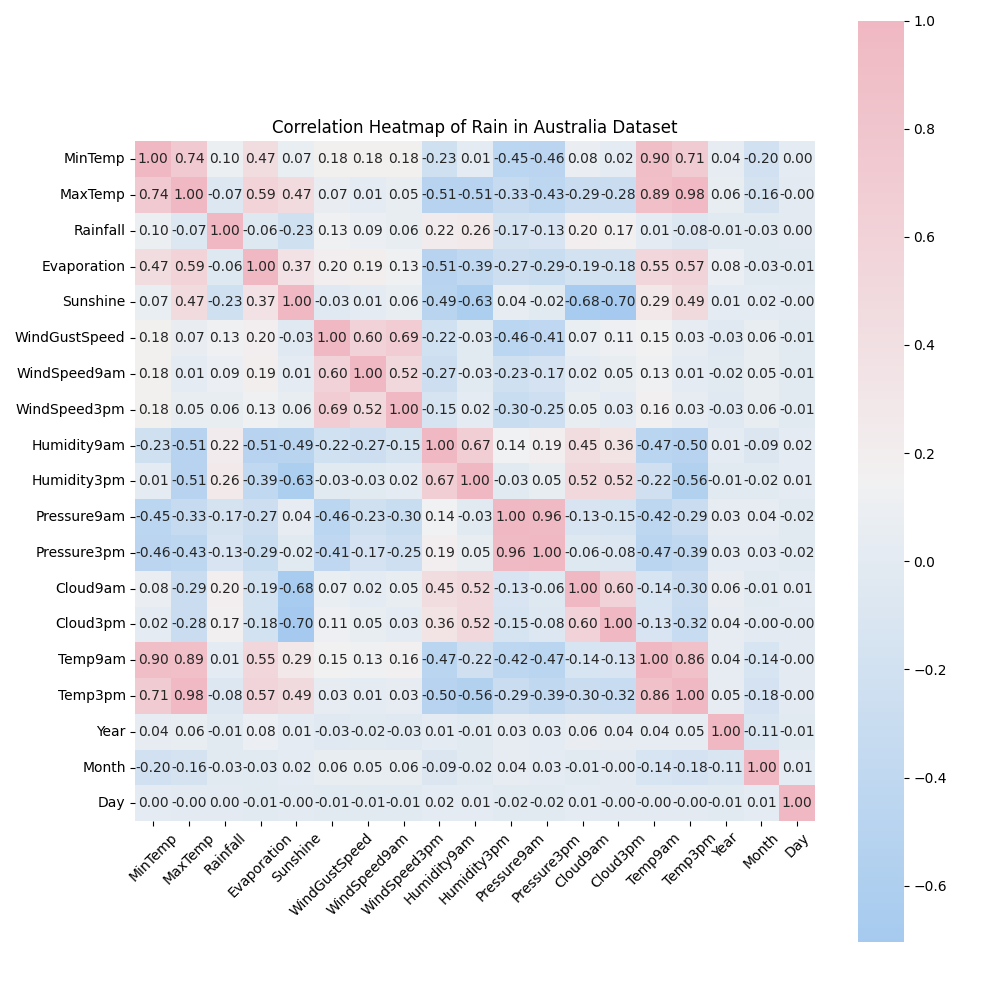

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Correlation Heatmap of Rain in Australia Dataset')
cmap = sns.diverging_palette(240, 0, s=70, l=80, as_cmap=True)
ax_sns = sns.heatmap(ax = ax, data=df[num_cols].corr(), cmap=cmap, square=True, annot=True, fmt='.2f', linecolor='white')
ax_sns.set_xticklabels(ax_sns.get_xticklabels(), rotation=45)
ax_sns.set_yticklabels(ax_sns.get_yticklabels(), rotation=0)
plt.subplots_adjust(bottom=0.15)
fig.tight_layout()
plt.show()

##### Заполним отсутствующие значения

In [44]:
# Выделим названия количенственных признаков в отдельный массив
num_cols = [var for var in df.columns if not df[var].dtype == 'object']
df[num_cols].isnull().sum()

MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustSpeed     9270
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
Year                 0
Month                0
Day                  0
dtype: int64

In [45]:
# Заполнение с исправленной сигнатурой метода
for col in num_cols:
    df.fillna({col: df[col].median()}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   MinTemp        142193 non-null  float64
 2   MaxTemp        142193 non-null  float64
 3   Rainfall       142193 non-null  float64
 4   Evaporation    142193 non-null  float64
 5   Sunshine       142193 non-null  float64
 6   WindGustDir    142193 non-null  object 
 7   WindGustSpeed  142193 non-null  float64
 8   WindDir9am     142193 non-null  object 
 9   WindDir3pm     142193 non-null  object 
 10  WindSpeed9am   142193 non-null  float64
 11  WindSpeed3pm   142193 non-null  float64
 12  Humidity9am    142193 non-null  float64
 13  Humidity3pm    142193 non-null  float64
 14  Pressure9am    142193 non-null  float64
 15  Pressure3pm    142193 non-null  float64
 16  Cloud9am       142193 non-null  float64
 17  Cloud3pm       142193 non-null  fl

#### Кодирование категориальных признаков
##### Признак `Location`
Перекодируем наш признак с использованием `One-Hot Encoder`.

$$
\begin{bmatrix}
    \text{Adelaide} \\[0.3em]
    \text{Albany}   \\[0.3em]
    \text{Albury}   \\[0.3em]
    \cdots          \\[0.3em]
    \text{Woomera}  \\[0.3em]
\end{bmatrix}_{\; 49 \times 1} \quad \rightarrow{} \quad
\begin{bmatrix}
    1 & 0 & 0 & \cdots & 0 \\[0.3em]
    0 & 1 & 0 & \cdots & 0 \\[0.3em]
    0 & 0 & 1 & \cdots & 0 \\[0.3em]
    \vdots & \vdots & \vdots & \ddots & 0 \\[0.3em]
    0 & 0 & 0 & \cdots & 1 \\[0.3em]
\end{bmatrix}_{\; 49 \times 49}
$$

In [46]:
df_loc_dummy = pd.get_dummies(df.Location, prefix='Location')
df_loc_dummy

,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,...,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
145455,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
145456,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
145457,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [47]:
df = df.drop('Location', axis = 1)
df = df.join(df_loc_dummy)
df.info(max_cols=20)

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Columns: 73 entries, MinTemp to Location_Woomera
dtypes: bool(49), float64(16), int32(3), object(5)
memory usage: 32.1+ MB


In [48]:
# Оставшиеся категориальные признаки
cat_left = [var for var in df.columns if df[var].dtype == 'object']
cat_left

['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

##### Закодируем категориальные признаки направления ветра `OneHotEncoder`'ом

In [49]:
cat_left = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
df = pd.get_dummies(data=df, columns=cat_left)
df.info(max_cols=20)

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Columns: 118 entries, MinTemp to WindDir3pm_WSW
dtypes: bool(97), float64(16), int32(3), object(2)
memory usage: 35.4+ MB


In [50]:
list(df.columns)

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'RainTomorrow',
 'Year',
 'Month',
 'Day',
 'Location_Adelaide',
 'Location_Albany',
 'Location_Albury',
 'Location_AliceSprings',
 'Location_BadgerysCreek',
 'Location_Ballarat',
 'Location_Bendigo',
 'Location_Brisbane',
 'Location_Cairns',
 'Location_Canberra',
 'Location_Cobar',
 'Location_CoffsHarbour',
 'Location_Dartmoor',
 'Location_Darwin',
 'Location_GoldCoast',
 'Location_Hobart',
 'Location_Katherine',
 'Location_Launceston',
 'Location_Melbourne',
 'Location_MelbourneAirport',
 'Location_Mildura',
 'Location_Moree',
 'Location_MountGambier',
 'Location_MountGinini',
 'Location_Newcastle',
 'Location_Nhil',
 'Location_NorahHead',
 'Location_NorfolkIsland',
 'Location_Nuriootpa',
 'Location_PearceRAAF',
 'Location_Penrith',
 'Locati

##### Преобразуем бинарные признаки `RainToday` и `RainTomorrow`

In [51]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = False)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = False)

C:\Users\UD\AppData\Local\Temp\ipykernel_127700\15541216.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = False)
C:\Users\UD\AppData\Local\Temp\ipykernel_127700\15541216.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = False)


0         0
1         0
2         0
3         0
4         0
         ..
145454    0
145455    0
145456    0
145457    0
145458    0
Name: RainTomorrow, Length: 142193, dtype: int64

In [52]:
df['RainToday'].replace({'No': '0', 'Yes': '1'}, inplace = False)
df['RainTomorrow'].replace({'No': '0', 'Yes': '1'}, inplace = False)

0         0
1         0
2         0
3         0
4         0
         ..
145454    0
145455    0
145456    0
145457    0
145458    0
Name: RainTomorrow, Length: 142193, dtype: object

In [53]:
df.replace({'RainToday': {'No': '0', 'Yes': '1'}}, inplace = True)
df.replace({'RainTomorrow': {'No': '0', 'Yes': '1'}}, inplace = True)
df['RainToday'] = df['RainToday'].astype(int)
df['RainTomorrow'] = df['RainTomorrow'].astype(int)

In [54]:
df.corr()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
MinTemp,1.000000,0.733894,0.103205,0.367429,0.030522,0.172719,0.175126,0.174226,-0.232714,0.006051,...,-0.070040,-0.063033,-0.008666,0.054754,0.023415,-0.036230,-0.044590,-0.077080,-0.046412,-0.059007
MaxTemp,0.733894,1.000000,-0.073862,0.451038,0.315760,0.066930,0.014805,0.050309,-0.500179,-0.499633,...,-0.008401,-0.008286,-0.056929,0.005194,-0.013910,-0.061866,-0.054141,-0.068496,-0.025975,-0.060938
Rainfall,0.103205,-0.073862,1.000000,-0.041952,-0.171138,0.126684,0.085595,0.056578,0.221110,0.249128,...,-0.017834,-0.005374,0.019349,0.008454,0.013051,0.027093,0.008868,0.015141,0.008490,0.013812
Evaporation,0.367429,0.451038,-0.041952,1.000000,0.280239,0.149878,0.149461,0.101024,-0.388191,-0.297478,...,-0.030444,-0.023983,-0.009258,0.008259,0.012350,-0.003675,0.007159,-0.025311,-0.026634,-0.007370
Sunshine,0.030522,0.315760,-0.171138,0.280239,1.000000,-0.030410,-0.012140,0.023224,-0.330731,-0.432368,...,-0.014016,-0.002383,-0.032203,0.012839,-0.007637,-0.022760,0.010702,-0.014169,-0.007743,0.001450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WindDir3pm_SSW,-0.036230,-0.061866,0.027093,-0.003675,-0.022760,-0.002876,0.012964,-0.005451,0.027387,0.028330,...,-0.058593,-0.061483,-0.065735,-0.082145,-0.064044,1.000000,-0.064194,-0.066877,-0.062205,-0.064741
WindDir3pm_SW,-0.044590,-0.054141,0.008868,0.007159,0.010702,0.006939,-0.002473,0.007757,-0.006348,-0.007276,...,-0.063009,-0.066116,-0.070689,-0.088336,-0.068871,-0.064194,1.000000,-0.071917,-0.066893,-0.069621
WindDir3pm_W,-0.077080,-0.068496,0.015141,-0.025311,-0.014169,0.089701,0.028744,0.060718,0.000454,-0.020279,...,-0.065643,-0.068880,-0.073644,-0.092029,-0.071750,-0.066877,-0.071917,1.000000,-0.069689,-0.072531
WindDir3pm_WNW,-0.046412,-0.025975,0.008490,-0.026634,-0.007743,0.085642,0.014721,0.054215,-0.001642,-0.035381,...,-0.061057,-0.064068,-0.068499,-0.085600,-0.066737,-0.062205,-0.066893,-0.069689,1.000000,-0.067464


##### Выбросы (outliers)

In [55]:
import copy
num_cols_ext = copy.deepcopy(num_cols)
num_cols_ext.append('RainToday')

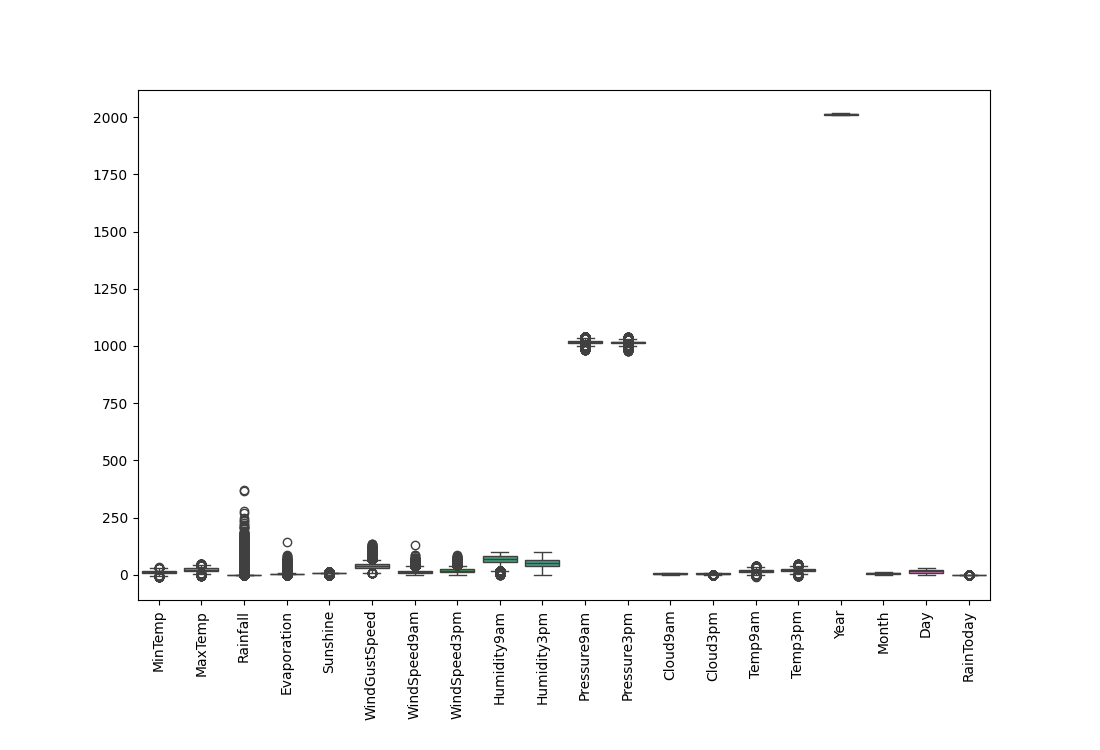

In [56]:
fig, ax = plt.subplots(figsize=(11, 7.5))
sns.boxplot(data = df[num_cols_ext], ax = ax)
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=90)
plt.show()

##### Нормализация признаков

In [57]:
df[num_cols_ext].describe().T

,count,mean,std,min,25%,50%,75%,max
MinTemp,142193.0,12.185565,6.388936,-8.5,7.6,12.0,16.8,33.9
MaxTemp,142193.0,23.225365,7.109617,-4.8,17.9,22.6,28.2,48.1
Rainfall,142193.0,2.326738,8.426426,0.0,0.0,0.0,0.6,371.0
Evaporation,142193.0,5.183213,3.185401,0.0,4.0,4.8,5.4,145.0
Sunshine,142193.0,8.042236,2.769638,0.0,8.2,8.5,8.7,14.5
WindGustSpeed,142193.0,39.920123,13.140632,6.0,31.0,39.0,46.0,135.0
WindSpeed9am,142193.0,13.992489,8.851614,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,142193.0,18.644279,8.721688,0.0,13.0,19.0,24.0,87.0
Humidity9am,142193.0,68.858235,18.932512,0.0,57.0,70.0,83.0,100.0
Humidity3pm,142193.0,51.495742,20.532227,0.0,37.0,52.0,65.0,100.0


In [58]:
all_cols = list(df.columns)
mm_scaler = sklearn.preprocessing.MinMaxScaler()
features_scaled = mm_scaler.fit_transform(df[all_cols])
df_scaled = pd.DataFrame(features_scaled, columns=all_cols)
df_scaled

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,0.516509,0.523629,0.001617,0.033103,0.586207,0.294574,0.153846,0.275862,0.71,0.22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.375000,0.565217,0.000000,0.033103,0.586207,0.294574,0.030769,0.252874,0.44,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.504717,0.576560,0.000000,0.033103,0.586207,0.310078,0.146154,0.298851,0.38,0.30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.417453,0.620038,0.000000,0.033103,0.586207,0.139535,0.084615,0.103448,0.45,0.16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.613208,0.701323,0.002695,0.033103,0.586207,0.271318,0.053846,0.229885,0.82,0.33,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,0.283019,0.502836,0.000000,0.033103,0.586207,0.193798,0.115385,0.149425,0.59,0.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142189,0.266509,0.533081,0.000000,0.033103,0.586207,0.193798,0.100000,0.126437,0.51,0.24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142190,0.285377,0.568998,0.000000,0.033103,0.586207,0.124031,0.100000,0.103448,0.56,0.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142191,0.327830,0.599244,0.000000,0.033103,0.586207,0.240310,0.069231,0.103448,0.53,0.24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [59]:
df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
MinTemp,142193.0,0.487867,0.150682,0.0,0.379717,0.483491,0.596698,1.0
MaxTemp,142193.0,0.529780,0.134397,0.0,0.429112,0.517958,0.623819,1.0
Rainfall,142193.0,0.006272,0.022713,0.0,0.000000,0.000000,0.001617,1.0
Evaporation,142193.0,0.035746,0.021968,0.0,0.027586,0.033103,0.037241,1.0
Sunshine,142193.0,0.554637,0.191009,0.0,0.565517,0.586207,0.600000,1.0
...,...,...,...,...,...,...,...,...
WindDir3pm_SSW,142193.0,0.056332,0.230562,0.0,0.000000,0.000000,0.000000,1.0
WindDir3pm_SW,142193.0,0.064574,0.245774,0.0,0.000000,0.000000,0.000000,1.0
WindDir3pm_W,142193.0,0.069701,0.254643,0.0,0.000000,0.000000,0.000000,1.0
WindDir3pm_WNW,142193.0,0.060875,0.239102,0.0,0.000000,0.000000,0.000000,1.0


##### Выбросы (ouliers) после нормализации

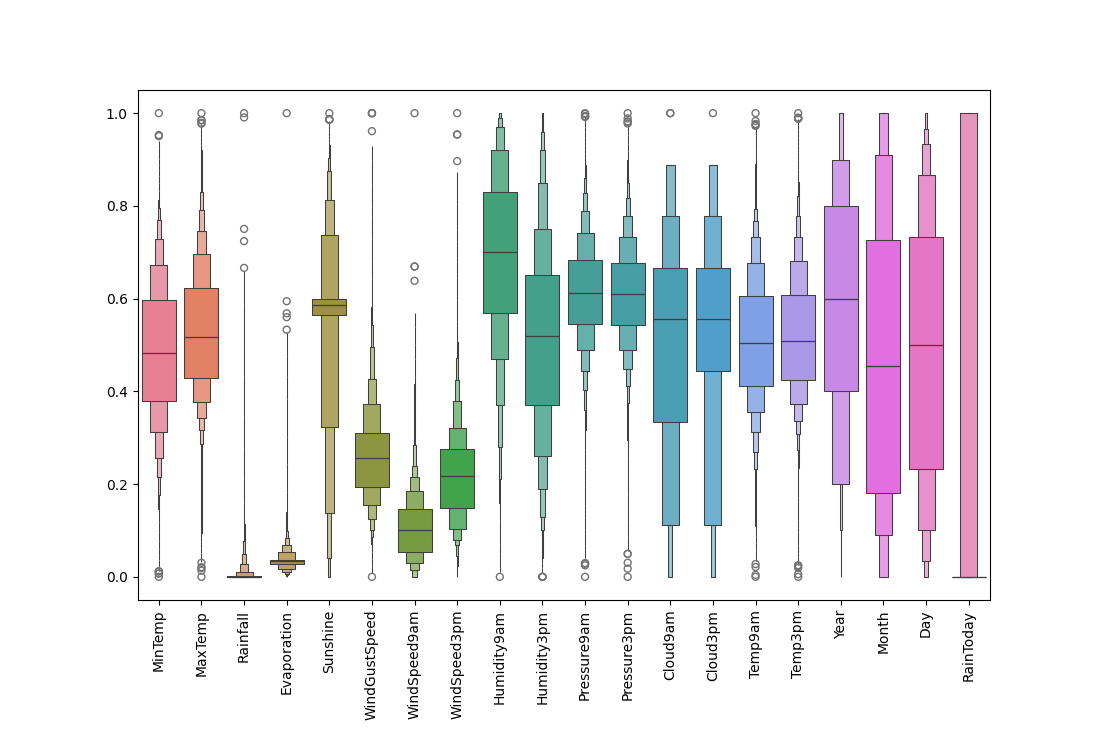

In [60]:
fig, ax = plt.subplots(figsize=(11, 7.5))
sns.boxenplot(data = df_scaled[num_cols_ext], ax = ax)
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=90)
plt.show()

##### Подправим outliers

In [61]:
df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
MinTemp,142193.0,0.487867,0.150682,0.0,0.379717,0.483491,0.596698,1.0
MaxTemp,142193.0,0.529780,0.134397,0.0,0.429112,0.517958,0.623819,1.0
Rainfall,142193.0,0.006272,0.022713,0.0,0.000000,0.000000,0.001617,1.0
Evaporation,142193.0,0.035746,0.021968,0.0,0.027586,0.033103,0.037241,1.0
Sunshine,142193.0,0.554637,0.191009,0.0,0.565517,0.586207,0.600000,1.0
...,...,...,...,...,...,...,...,...
WindDir3pm_SSW,142193.0,0.056332,0.230562,0.0,0.000000,0.000000,0.000000,1.0
WindDir3pm_SW,142193.0,0.064574,0.245774,0.0,0.000000,0.000000,0.000000,1.0
WindDir3pm_W,142193.0,0.069701,0.254643,0.0,0.000000,0.000000,0.000000,1.0
WindDir3pm_WNW,142193.0,0.060875,0.239102,0.0,0.000000,0.000000,0.000000,1.0


Определим границы ящика с усами.

In [62]:
def get_bounds(dataframe, col):
    iqr = dataframe[col].quantile(0.75) - dataframe[col].quantile(0.25)
    lower_bound = dataframe[col].quantile(0.25) - 1.5 * iqr
    upper_bound = dataframe[col].quantile(0.75) + 1.5 * iqr
    return lower_bound, upper_bound

In [63]:
num_cols_clean = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

bounds_dict = dict()

for col in num_cols_clean:
    lb, ub = get_bounds(df_scaled, col)
    bounds_dict[col] = [lb, ub]
    print(f"{col:<13} outliers are values < {lb:.2f} or > {ub:.2f}")

MinTemp       outliers are values < 0.05 or > 0.92
MaxTemp       outliers are values < 0.14 or > 0.92
Rainfall      outliers are values < -0.00 or > 0.00
Evaporation   outliers are values < 0.01 or > 0.05
Sunshine      outliers are values < 0.51 or > 0.65
WindGustSpeed outliers are values < 0.02 or > 0.48
WindSpeed9am  outliers are values < -0.08 or > 0.28
WindSpeed3pm  outliers are values < -0.04 or > 0.47
Humidity9am   outliers are values < 0.18 or > 1.22
Humidity3pm   outliers are values < -0.05 or > 1.07
Pressure9am   outliers are values < 0.34 or > 0.89
Pressure3pm   outliers are values < 0.34 or > 0.88
Cloud9am      outliers are values < -0.17 or > 1.17
Cloud3pm      outliers are values < 0.11 or > 1.00
Temp9am       outliers are values < 0.12 or > 0.90
Temp3pm       outliers are values < 0.15 or > 0.88


In [64]:
df[num_cols_clean].count()

MinTemp          142193
MaxTemp          142193
Rainfall         142193
Evaporation      142193
Sunshine         142193
WindGustSpeed    142193
WindSpeed9am     142193
WindSpeed3pm     142193
Humidity9am      142193
Humidity3pm      142193
Pressure9am      142193
Pressure3pm      142193
Cloud9am         142193
Cloud3pm         142193
Temp9am          142193
Temp3pm          142193
dtype: int64

In [65]:
from copy import deepcopy


def clean_data(df, bounds_dict: dict):
    df_clean = deepcopy(df)
    print(df_clean.shape)

    for k, v in bounds_dict.items():
        arr = np.array((df_clean[k] > v[0]) & (df_clean[k] < v[1])).reshape((-1, 1))
        print(f"{k}: bounds: {v}")
        print(f"  old: {df_clean[k].shape[0]}, new: {np.count_nonzero(arr)}, diff: {np.count_nonzero(arr) - df_clean[k].shape[0]}")
        df_clean = df_clean[(df_clean[k] > v[0]) & (df_clean[k] < v[1])]
    return df_clean


df_clean = clean_data(df_scaled, bounds_dict)

(142193, 118)
MinTemp: bounds: [0.05424528301886805, 0.9221698113207546]
  old: 142193, new: 142128, diff: -65
MaxTemp: bounds: [0.13705103969754245, 0.9158790170132325]
  old: 142128, new: 141699, diff: -429
Rainfall: bounds: [-0.002425876010781671, 0.004043126684636119]
  old: 141699, new: 113303, diff: -28396
Evaporation: bounds: [0.013103448275862063, 0.05172413793103449]
  old: 113303, new: 87300, diff: -26003
Sunshine: bounds: [0.5137931034482757, 0.6517241379310346]
  old: 87300, new: 57469, diff: -29831
WindGustSpeed: bounds: [0.01937984496124026, 0.4844961240310078]
  old: 57469, new: 55906, diff: -1563
WindSpeed9am: bounds: [-0.08461538461538462, 0.2846153846153846]
  old: 55906, new: 55545, diff: -361
WindSpeed3pm: bounds: [-0.0402298850574713, 0.4655172413793104]
  old: 55545, new: 55117, diff: -428
Humidity9am: bounds: [0.18000000000000005, 1.2200000000000002]
  old: 55117, new: 54724, diff: -393
Humidity3pm: bounds: [-0.050000000000000044, 1.07]
  old: 54724, new: 54724, 

In [66]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49870 entries, 0 to 142192
Columns: 118 entries, MinTemp to WindDir3pm_WSW
dtypes: float64(118)
memory usage: 45.3 MB


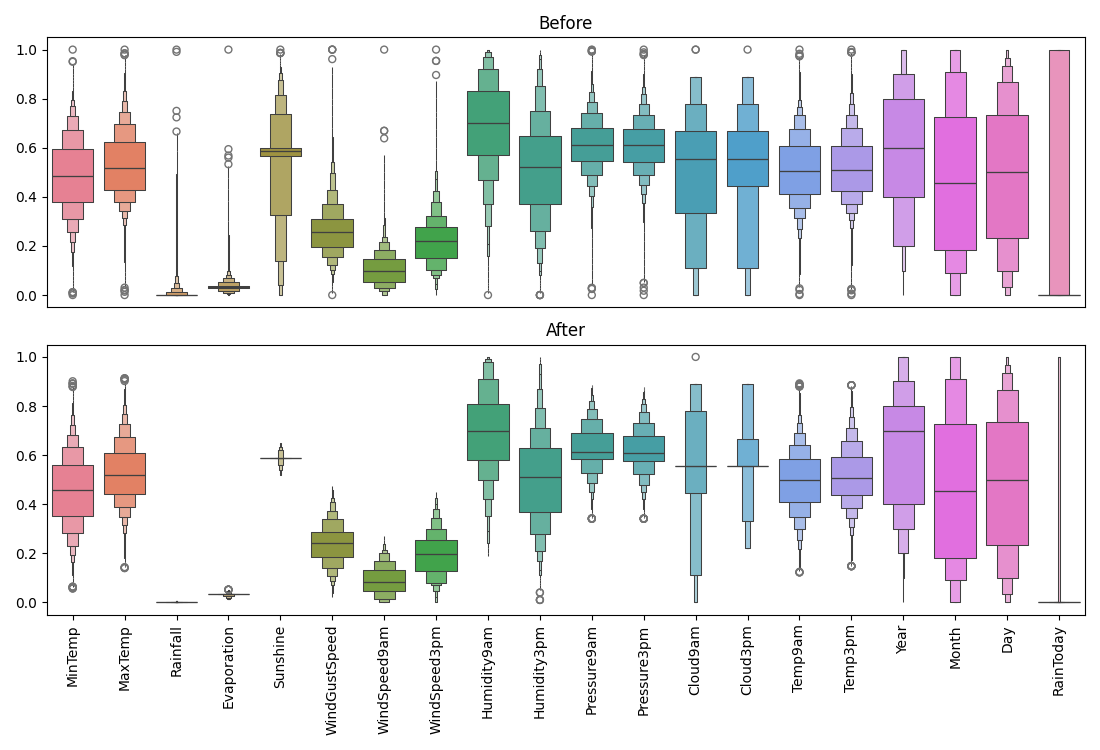

In [67]:
fig, ax = plt.subplots(2, 1, figsize=(11, 7.5))
sns.boxenplot(data = df_scaled[num_cols_ext], ax = ax[0])
ax[0].set_xticks([])
ax[0].title.set_text('Before')
sns.boxenplot(data = df_clean[num_cols_ext], ax = ax[1])
ax[1].title.set_text('After')
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=90)
fig.tight_layout()
plt.show()

In [68]:
X = df_clean.drop(['RainTomorrow'], axis=1)

In [69]:
y = df_clean['RainTomorrow']

In [70]:
X.shape, y.shape

((49870, 117), (49870,))

### 3.7 Обучение и предсказание

In [71]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=3)

#### Разделение выборки на обучающую и тестовую

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
print(y_train.shape, y_test.shape)
model_knn.fit(X_train, y_train)

(37402,) (12468,)


KNeighborsClassifier(n_neighbors=3)

### 3.8 Оценка качества модели

In [73]:
y_pred = model_knn.predict(X_test)
# Ручками
print(f"Test accuracy: {np.mean( y_pred == y_test ):.2f}")

C:\Dev\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Dev\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Dev\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Dev\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Dev\Python\Python310\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Test accuracy: 0.82


In [74]:
# Методом score
model_knn.score(X_test, y_test)

0.8202598652550529

In [75]:
# accuracy_score в sklearn
sklearn.metrics.accuracy_score(y_pred, y_test)

0.8202598652550529

#### Точность модели в зависимости от значения гиперпараметра

In [76]:
training_accuracy = []
test_accuracy = []
neighbors_settings = range(1, 16)
for n_neighbors in neighbors_settings:
  clf = KNeighborsClassifier(n_neighbors = n_neighbors)
  clf.fit(X_train, y_train)
  training_accuracy.append(clf.score(X_train, y_train))
  test_accuracy.append(clf.score(X_test, y_test))

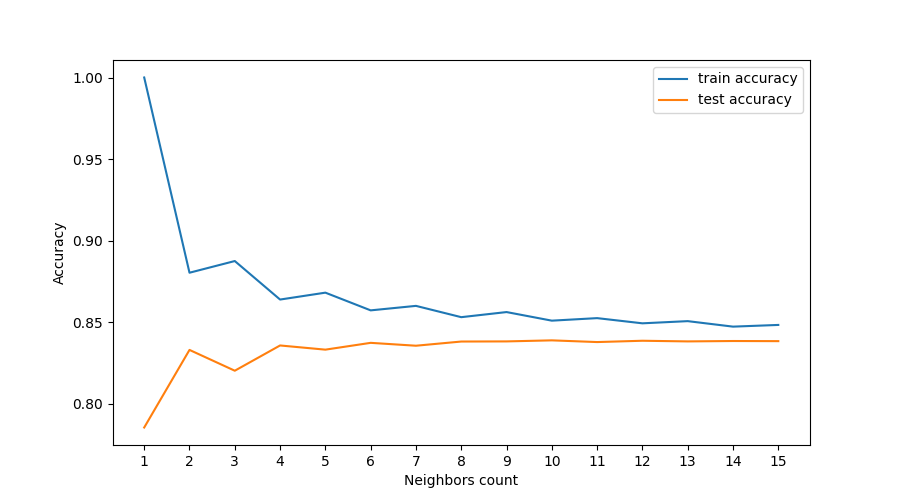

In [77]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(neighbors_settings, training_accuracy, label="train accuracy")
ax.plot(neighbors_settings, test_accuracy, label="test accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Neighbors count")
ax.set_xticks(range(1, 16))
ax.legend()

#### Кросс-валидация (перекрёстная проверка)

Перекрестная проверка (кросс-валидация) представляет собой статистический метод оценки обобщающей способности, который является более устойчивым и точным, чем разбиение данных на обучающий и тестовый наборы. В перекрестной проверке данные разбиваются несколько раз и строится несколько моделей. Наиболее часто используемый вариант перекрестной проверки &ndash; $k$-блочная кросс-валидация ($k$-fold cross-validation), в которой $k$ &ndash; это задаваемое пользователем число, как правило, $5$ или $10$.

![crossval-1](https://bitbucket.org/despairr/ds-course-2018/raw/443959e3b5e41168ceba4adcffbe1e9e9084f246/intro-to-ml-images/927.png)

В `scikit-learn` перекрестная проверка реализована с помощью функции [sklern.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [78]:
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 3)
scores = sklearn.model_selection.cross_val_score(clf, X, y, cv = 3)
print(f"Scores: {scores}\nAvg score: {scores.mean()}")

Scores: [0.80672522 0.80761595 0.81820369]
Avg score: 0.8108482880102557


In [79]:
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 3)
scores = sklearn.model_selection.cross_val_score(clf, X, y, cv = 5)
print(f"Scores: {scores}\nAvg score: {scores.mean()}")

Scores: [0.79917786 0.81431722 0.81070784 0.81852817 0.81892922]
Avg score: 0.8123320633647483


In [80]:
knn_k_list = range(1, 16)
cv_k = 10
for knn_k in knn_k_list:
    clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors = knn_k)
    scores = sklearn.model_selection.cross_val_score(clf, X, y, cv = cv_k)
    print(f"Neighbors: {knn_k}, folds count: {cv_k} avg score: {scores.mean()}")

Neighbors: 1, folds count: 10 avg score: 0.7582514537798276
Neighbors: 2, folds count: 10 avg score: 0.8253458993382796
Neighbors: 3, folds count: 10 avg score: 0.8049328253458994
Neighbors: 4, folds count: 10 avg score: 0.8322438339683176
Neighbors: 5, folds count: 10 avg score: 0.8243232404251053
Neighbors: 6, folds count: 10 avg score: 0.836394626027672
Neighbors: 7, folds count: 10 avg score: 0.8321836775616603
Neighbors: 8, folds count: 10 avg score: 0.8389813515139363
Neighbors: 9, folds count: 10 avg score: 0.836575095247644
Neighbors: 10, folds count: 10 avg score: 0.8399438540204531
Neighbors: 11, folds count: 10 avg score: 0.8395027070382997
Neighbors: 12, folds count: 10 avg score: 0.8406657309003409
Neighbors: 13, folds count: 10 avg score: 0.8403248445959495
Neighbors: 14, folds count: 10 avg score: 0.8412873471024664
Neighbors: 15, folds count: 10 avg score: 0.8410667736113897


#### Стратифицированная $k$-блочная кросс-валидация

![crossval-2](https://bitbucket.org/despairr/ds-course-2018/raw/443959e3b5e41168ceba4adcffbe1e9e9084f246/intro-to-ml-images/957.png)

В стратифицированной перекрестной проверке мы разбиваем данные таким образом, чтобы пропорции классов в каждом блоке в точности соответствовали пропорциям классов в наборе данных.

In [81]:
knn_k_list = range(1, 16)
cv_k = 10
cvgen = sklearn.model_selection.StratifiedKFold(cv_k)
for knn_k in knn_k_list:
    clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors = knn_k)
    scores = sklearn.model_selection.cross_val_score(clf, X, y, cv = cvgen)
    print(f"Neighbors: {knn_k}, stratified folds count: {cv_k} avg score: {scores.mean()}")

Neighbors: 1, stratified folds count: 10 avg score: 0.7582514537798276
Neighbors: 2, stratified folds count: 10 avg score: 0.8253458993382796
Neighbors: 3, stratified folds count: 10 avg score: 0.8049328253458994
Neighbors: 4, stratified folds count: 10 avg score: 0.8322438339683176
Neighbors: 5, stratified folds count: 10 avg score: 0.8243232404251053
Neighbors: 6, stratified folds count: 10 avg score: 0.836394626027672
Neighbors: 7, stratified folds count: 10 avg score: 0.8321836775616603
Neighbors: 8, stratified folds count: 10 avg score: 0.8389813515139363
Neighbors: 9, stratified folds count: 10 avg score: 0.836575095247644
Neighbors: 10, stratified folds count: 10 avg score: 0.8399438540204531
Neighbors: 11, stratified folds count: 10 avg score: 0.8395027070382997
Neighbors: 12, stratified folds count: 10 avg score: 0.8406657309003409
Neighbors: 13, stratified folds count: 10 avg score: 0.8403248445959495
Neighbors: 14, stratified folds count: 10 avg score: 0.8412873471024664
Nei

### 3.9 Метрики оценки точности бинарной классификации

В случае бинарной классификации мы говорим о положительном (positive) классе и отрицательном (negative) классе, подразумевая под положительным классом интересующий нас класс.

Ошибка первого рода ($\alpha$-ошибка, ложноположительное заключение) &ndash; ситуация, когда отвергнута верная нулевая гипотеза (об отсутствии связи между явлениями или искомого эффекта).
Ошибка второго рода ($\beta$-ошибка, ложноотрицательное заключение) &ndash; ситуация, когда принята неверная нулевая гипотеза.

<table style = "border: 1px solid black;">
    <caption>Confusion matrix</caption>
    <tr style = "border: 1px solid black;">
        <th rowspan=2 colspan=2 style = "border: 1px solid black;"></th>
        <th colspan=2 style = "border: 1px solid black;">Верная гипотеза</th>
    </tr>
    <tr style = "border: 1px solid black; background-color: rgba(255, 255, 255, 0.5);">
        <th style = "border: 1px solid black;">H<sub>0</sub></th>
        <th style = "border: 1px solid black;">H<sub>1</sub></th>
    </tr>
    <tr style = "border: 1px solid black;">
        <th rowspan=2 style = "border: 1px solid black;  background-color: rgba(255, 255, 255, 0.25);">Результат применения критерия</th>
        <th style = "border: 1px solid black;">H<sub>0</sub></th>
        <td style = "border: 1px solid black; background-color: rgba(0, 255, 0, 0.25); text-align: center;"><b>H<sub>0</sub></b> верно принята</td>
        <td style = "border: 1px solid black; background-color: rgba(255, 0, 0, 0.25); text-align: center;"><b>H<sub>0</sub></b> неверно принята<br>(ошибка второго рода)</td>
    </tr>
    <tr style = "border: 1px solid black;">
        <th style = "border: 1px solid black; background-color: rgb(255, 255, 255);">H<sub>1</sub></th>
        <td style = "border: 1px solid black; background-color: rgba(255, 0, 0, 0.25); text-align: center;"><b>H<sub>0</sub></b> неверно отвергнута<br>(ошибка первого рода)</td>
        <td style = "border: 1px solid black; background-color: rgba(0, 255, 0, 0.25); text-align: center;"><b>H<sub>0</sub></b> верно отвергнута</td>
    </tr>
</table>
<table style = "border: 1px solid black; font-size: 42px;">
    <tr>
        <td>
            TP
        </td>
        <td>
            FN
        </td>
    </tr>
    <tr>
        <td>
            FP
        </td>
        <td>
            TN
        </td>
    </tr>
</table>

In [82]:
def get_confusions(y_gt, y_pred):
    cm = sklearn.metrics.confusion_matrix(y_gt, y_pred)
    # tp fn fp tn
    return cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]

In [83]:
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
tp, fn, fp, tn = get_confusions(y_test, y_pred)
cm = [[tp, fn], [fp, tn]]

In [84]:
print(f"{cm[0]}\n{cm[1]}")

[85, 1952]
[63, 10368]


#### Accuracy

$$
Accuracy = \frac{ TP + TN  }{ TP + TN + FP + FN}
$$

Другими словами, правильность — это количество верно классифицированных примеров (TP и TN), поделенное на общее количество примеров

In [85]:
# Ручками
def get_accuracy(tp, fn, fp, tn):
    return (tp + tn) / (tp + tn + fp + fn)

In [86]:
print(f"Accuracy: {get_accuracy(tp, fn, fp, tn)}")

Accuracy: 0.8383862688482515


In [87]:
# accuracy_score в sklearn
sklearn.metrics.accuracy_score(y_test, y_pred)

0.8383862688482515

#### Точность (precision)

$$
Precision = \frac{ TP }{ TP + FP }
$$

Точность показывает, насколько можно доверять классификатору в случае срабатывания: сколько из предсказанных положительных примеров оказались действительно положительными.

Таким образом, точность – это доля истинно положительных примеров от общего количества предсказанных положительных примеров.

Точность используется в качестве показателя качества модели, когда цель состоит в том, чтобы снизить количество ложно положительных примеров.

Точность также известна как *прогностическая ценность положительного результата* (*positive predictive value*, *PPV*).

In [88]:
def get_precision(tp, fp):
    return tp / (tp + fp)

In [89]:
print(f"Precision: {get_precision(tp, fp)}")

Precision: 0.5743243243243243


In [90]:
# precision_score в sklearn
sklearn.metrics.precision_score(y_test, y_pred)

0.5743243243243243

#### Полнота (recall)

$$
Recall = \frac{ TP }{ TP + FN }
$$

*Полнота* (*recall*) показывает, на какой доле истинных объектов алгоритм срабатывает.
Другие названия *полноты*: *чувствительность* (*sensitivity*), *процент результативных ответов* или *хит-рейт* (*hit rate*) или *доля истинно положительных ответов* (*true positive rate*, *TPR*).

Полнота используется в качестве показателя качества модели, когда нам необходимо определить все положительные примеры, то есть, когда важно снизить количество ложно отрицательных примеров.

Нужно искать компромисс между оптимизацией полноты и оптимизацией точности. Можно получить идеальную полноту, спрогнозировав все примеры как положительные - не будет никаких ложно отрицательных и истинно отрицательных примеров. Однако прогнозирование всех примеров как положительных приведет к большому количеству ложно положительных примеров, и, следовательно, точность будет очень низкой.

In [91]:
def get_recall(tp, fn):
    return tp / (tp + fn)

In [92]:
print(f"Recall: {get_recall(tp, fn)}")

Recall: 0.041728031418753066


In [93]:
# recall_score в sklearn
sklearn.metrics.recall_score(y_test, y_pred)

0.041728031418753066

#### Интегральные метрики на основе *точности* и *полноты*
##### Арифметическое среднее
Единая метрика может быть получена как арифметическое среднее точности и полноты:
$$
A = \frac{1}{2} \cdot (precision + recall)
$$

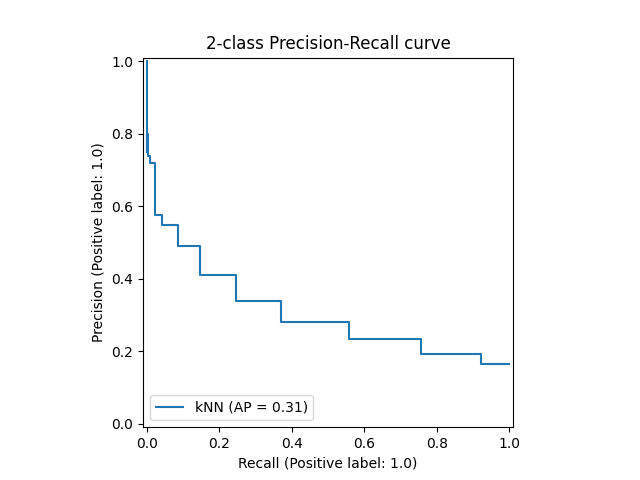

In [94]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, name="kNN"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")
display.ax_.set_aspect('equal', adjustable='box')

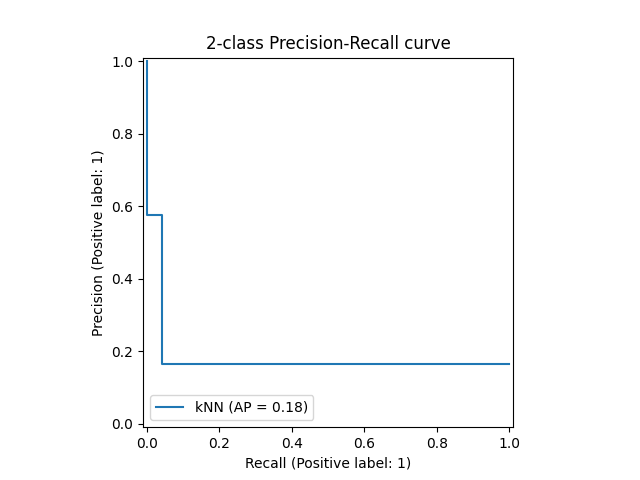

In [95]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(
    y_test, y_pred, name="kNN"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")
display.ax_.set_aspect('equal', adjustable='box')

#### Минимум (precision, recall)

$$
M = min(precision, recall)
$$

#### F-мера (f-measure)

Одним из способов подытожить их является *F-мера* (*F-measure*), которая представляет собой гармоническое среднее точности и полноты:

$$
F = 2 \cdot \frac{precision \cdot recall}{precision + recall}
$$

 Она стремится к нулю, если точность или полнота стремится к нулю.

Если необходимо отдать предпочтение точности или полноте, следует использовать расширенную F-меру, в которой есть параметр $\beta$:

$$
F = (1 + \beta^2) \cdot \frac{ precision \cdot recall }{ \beta^2 \cdot precision + recall }
$$

где $\beta$ принимает значения в диапазоне $0 < \beta < 1$, если вы хотите отдать приоритет точности, а при $\beta > 1$ приоритет отдается полноте. При $\beta = 1$ формула сводится к предыдущей и вы получаете сбалансированную F-меру (также ее называют F1).

*f-мера* действительно дает более лучшее представление о качестве модели, чем правильность. Однако, в отличие от *правильности*, ее труднее интерпретировать и объяснить.

#### `classification_report`

In [96]:
print(sklearn.metrics.classification_report(y_test, y_pred, target_names=["No rain tomorrow", "Rain tomorrow"]))

                  precision    recall  f1-score   support

No rain tomorrow       0.84      0.99      0.91     10431
   Rain tomorrow       0.57      0.04      0.08      2037

        accuracy                           0.84     12468
       macro avg       0.71      0.52      0.49     12468
    weighted avg       0.80      0.84      0.78     12468



#### Оценка принадлежности к классу, значения порога

Многие алгоритмы бинарной классификации устроены следующим образом: сначала вычисляется некоторое вещественное число $ b(x) $, которое сравнивается с порогом $ t $.

$$
a(x) = [b(x) > t],
$$

где $ b(x) $ — оценка принадлежности "положительному" классу.

Часто бывает необходимо оценить качество именно оценки принадлежности, а порог выбирается позже из соображений на точность или полноту.

![threshold](https://cloudfront.romexsoft.com/wp-content/uploads/2017/07/Shema_forThreshold_RomexColours-1.jpg.webp)

Пусть рассматривается задачного кредитного скоринга и была построена некоторая функция $b(x)$, которая оценивает вероятность возврата кредита клиентом $x$. Далее классификатор строится следующим образом:

$$
a(x) = [b(x) > 0.5]
$$

При этом получилось, что точность ($precision$) равна 10%, а полнота ($recall$) — 70%. Это очень плохой алгоритм, так как 90% клиентов, которым будет выдан кредит, не вернут его.
При этом непонятно, в чем дело: был плохо выбран порог или алгоритм не подходит для решения данной задачи. Именно для этого необходимо измерять качество самих оценок $b(x)$.

![binary-threshold](https://docs.aws.amazon.com/machine-learning/latest/dg/images/mlconcepts_image2.png)

#### ROC-кривая

Еще один инструмент, который обычно используется для анализа поведения классификаторов при различных пороговых значениях – это кривая *рабочей характеристики приемника* (*receiver operating characteristics curve*) или кратко *ROC-кривая* (*ROC curve*). Как и *кривая точности-полноты*, *ROC-кривая* позволяет рассмотреть все пороговые значения для данного классификатора, но вместо точности и полноты она показывает *долю ложно положительных примеров* (*false positive rate*, $FPR$) в сравнении с *долей истинно положительных примеров* (*true positive rate*, $TPR$).

$$
\begin{matrix}
    TPR = \frac{ TP }{ TP + FN } \\
    FPR = \frac{ FP }{ FP + TN }
\end{matrix}
$$

*Доля истинно положительных примеров* – это просто еще одно название *полноты*, тогда как *доля ложно положительных примеров* – это доля ложно положительных примеров от
общего количества отрицательных примеров.

ROC-кривая строится строится в осях *False Positive Rate* (ось $X$) и *True Positive Rate* (ось $Y$), аналогично $PR$-кривой: постепенно рассматриваются случаи различных значений порогов и отмечаются точки на графике.

![ROC-1](https://bitbucket.org/despairr/ds-course-2018/raw/c3f5df9d66d44fe424b4a4f0c0a0195f0ff9b0f7/intro-to-ml-images/1112.png)

![ROC-1](https://bitbucket.org/despairr/ds-course-2018/raw/c3f5df9d66d44fe424b4a4f0c0a0195f0ff9b0f7/intro-to-ml-images/1113.png)

Кривая стартует с точки $(0, 0)$ и приходит в точку $(1, 1)$. При этом, если существует идеальный классификатор, кривая должна пройти через точку $(0, 1)$. Чем ближе кривая к этой точке, тем лучше будут оценки, а площадь под кривой будет характеризовать качество оценок принадлежности к первому классу. Такая метрика называется $\textit{AUC-ROC}$, или площадь под $ROC$-кривой.

В случае идеального алгоритма $AUC-ROC = 1$, а в случае худшего $AUC-ROC = \frac{1}{2}$. Значение $\textit{AUC-ROC}$ имеет смысл вероятности того, что если были выбраны случайный положительный и случайный отрицаельный объекты выборки, положительный объект получит оценку принадлежности выше, чем отрицательный объект.

In [97]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.6937954758640917